In [1]:
from simulation import *
from config import *
from surfer import *
from wave import *
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def summarize(res):
    print(f"Wave Count:        {res['wave_counts']}")
    print(f"Number of surfers: {res['n_surfers']}")
    print(f"Success rate:      {res['success_rate']:.2f}")
    print(f"Collision rate:    {res['collision_rate']:.2f}")
    print(f"Waiting:           {res['avg_waiting_time']:.2f}")
    print(f"Fairness:          {res['fairness']:.3f}")

In [3]:
def run_many(
        number_of_runs=20,
        mode=None,
        spot_level=None,
        rule_type=None,
        num_surfer=None,
        ratio=None,
        spot_conf=None,
        wave_schedule=None,
        duration=None,
):
    """
    Run multiple simulations and return (mean, std) of the results
    """
    if mode is None:
        mode=EXPR_CONF["mode"]
    if spot_level is None:
        spot_level=SPOT_LEVEL
    if rule_type is None:
        rule_type=RULE_TYPE
    if spot_conf is None:
        spot_conf=SPOT_CONF[spot_level]
    if duration is None:
        duration=SESSION_DURATION

    results = []

    for _ in range(number_of_runs):
        res = run_simulation(
            mode=mode,
            spot_level=spot_level,
            rule_type=rule_type,
            num_surfer=num_surfer,
            ratio=ratio if mode == "experiment" else None,
            spot_conf=spot_conf,
            wave_schedule=wave_schedule,
            duration=duration,
        )
        res_metrics = {
            "n_surfers": res["n_surfers"], 
            "wave_counts": res["wave_counts"], 
            "success_rate": res["success_rate"], 
            "collision_rate": res["collision_rate"], 
            "avg_waiting_time": res["avg_waiting_time"],
            "fairness": res["fairness"]
        }
        results.append(res_metrics)

    df = pd.DataFrame(results)
    return df.mean(), df.std()

In [4]:
def summary_table(mean, std, label_name="condition"):

    rows = []

    conditions = []
    for key in mean.keys():
        cond = key.replace("_mean", "")
        conditions.append(cond)      

    first_cond = conditions[0]
    metrics = mean[f"{first_cond}_mean"].keys()

    for cond in conditions:
        mean_vals = mean[f"{cond}_mean"]
        std_vals = std[f"{cond}_std"]
    
        for metric in metrics:
            rows.append({
                label_name: cond,
                "metric": metric,
                "mean": mean_vals[metric],
                "std": std_vals[metric]
            })

    return pd.DataFrame(rows)

# Validation 📑

### 1. Zero-wave session（0 wave）

This test covers an edge case where the wave schedule is empty, i.e., no waves are generated. Even though surfers are present in the simulation, no riding can occur. As a result, all statistics (success rate, collision rate, average waiting time, and fairness) should correctly evaluate to zero. With no opportunities to ride, there is also no competition among surfers, making fairness zero.

In [8]:
res = run_simulation(wave_schedule=[])
res

{'spot_level': 'beginner',
 'n_surfers': 62,
 'beginner_ratio': None,
 'wave_counts': 0,
 'success_rate': 0.0,
 'collision_rate': 0.0,
 'avg_waiting_time': 3600.0,
 'fairness': 0.0}

### 2. Single-surfer session（1 surfer）

This test checks the case where only one surfer is present in the simulation. With no competitors, collisions should never occur, and fairness is naturally zero. The surfer can still ride waves normally, so the success-related statistics should remain valid.

In [11]:
res = run_simulation(mode="experiment", num_surfer=1, ratio=0)
res

{'spot_level': 'beginner',
 'n_surfers': 1,
 'beginner_ratio': 0,
 'wave_counts': 2066,
 'success_rate': 30.0,
 'collision_rate': 0.0,
 'avg_waiting_time': 115.66666666666667,
 'fairness': 0.0}

### 3. Zero surfers（empty beach）

This test the case where no surfer exists in the simulation. Even though there are waves during the simulation, no surfer will ride those waves. Accordingly, the statistics related to surfing activity should be zeros.

In [14]:
res = run_simulation(mode="experiment", num_surfer=0, ratio=0)
res

{'spot_level': 'beginner',
 'n_surfers': 0,
 'beginner_ratio': 0,
 'wave_counts': 2205,
 'success_rate': 0.0,
 'collision_rate': 0.0,
 'avg_waiting_time': 3600.0,
 'fairness': 0.0}

### 4. Infinite waves (long duration)

This is a stress test to check if the program still works noramlly in some extreme conditions, such as long duration.

In [17]:
results_val4 = []

for dur in [1000, 2000, 5000, 10000, 20000, 40000]:
    res = run_simulation(duration=dur)
    res["session_duration"] = dur
    results_val4.append(res)

In [18]:
df_val4 = pd.DataFrame(results_val4).set_index("session_duration")
df_val4

,spot_level,n_surfers,beginner_ratio,wave_counts,success_rate,collision_rate,avg_waiting_time,fairness
session_duration,,,,,,,,
1000,beginner,88,None,579,2.352273,9.454545,936.019324,0.600736
2000,beginner,57,None,1223,6.087719,15.912281,332.734870,0.491835
5000,beginner,45,None,2976,16.066667,38.711111,242.525588,0.409467
10000,beginner,70,None,5904,20.271429,94.142857,389.162086,0.506121
20000,beginner,100,None,11658,32.240000,198.280000,504.221154,0.537488
40000,beginner,71,None,23326,82.704225,379.169014,453.880279,0.473150


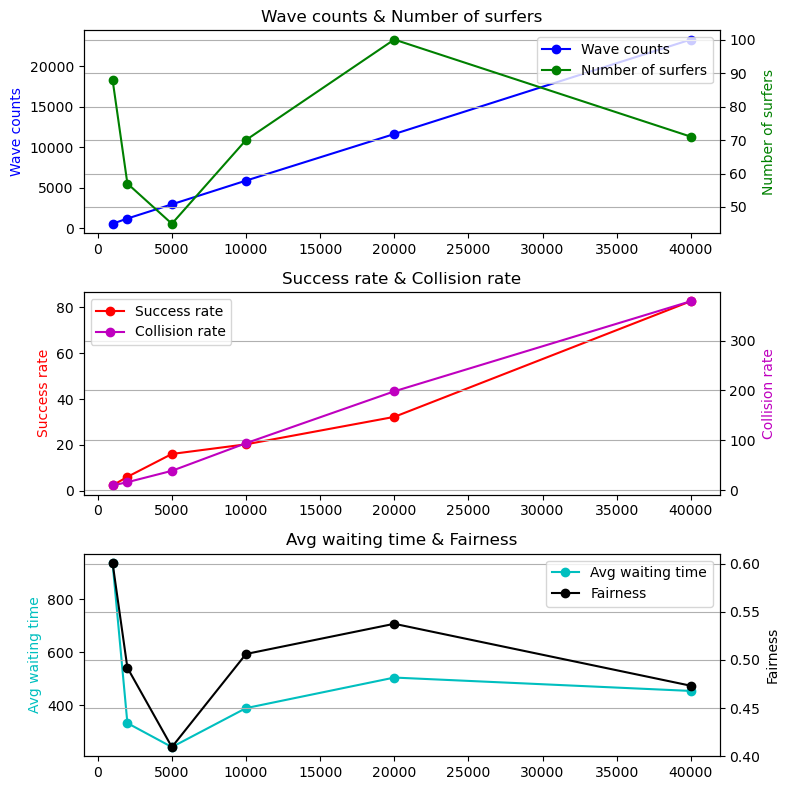

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8))

# -- Subplot 1: Wave counts & Number of surfers --
ax1 = axes[0]
ax1.set_title("Wave counts & Number of surfers")   

(ln1,) = ax1.plot(df_val4.index, df_val4['wave_counts'], 'b-o', label="Wave counts")
ax1.set_ylabel("Wave counts", color='b')

ax1r = ax1.twinx()
(ln2,) = ax1r.plot(df_val4.index, df_val4['n_surfers'], 'g-o', label="Number of surfers")
ax1r.set_ylabel("Number of surfers", color='g')

plt.legend([ln1, ln2], [ln1.get_label(), ln2.get_label()], loc="best")
plt.grid()

# -- Subplot 2: Wave counts & Number of surfers --
ax2 = axes[1]
ax2.set_title("Success rate & Collision rate")

(ln3, ) = ax2.plot(df_val4.index, df_val4['success_rate'], "r-o", label="Success rate")
ax2.set_ylabel("Success rate", color='r')

ax2r = ax2.twinx()
(ln4,) = ax2r.plot(df_val4.index, df_val4['collision_rate'], 'm-o', label="Collision rate")
ax2r.set_ylabel("Collision rate", color='m')

plt.legend([ln3, ln4], [ln3.get_label(), ln4.get_label()], loc="best")
plt.grid()

# -- Subplot 3: Wave counts & Number of surfers --
ax3 = axes[2]
ax3.set_title("Avg waiting time & Fairness")

(ln5, ) = ax3.plot(df_val4.index, df_val4['avg_waiting_time'], "c-o", label="Avg waiting time")
ax3.set_ylabel("Avg waiting time", color='c')

ax3r = ax3.twinx()
(ln6,) = ax3r.plot(df_val4.index, df_val4['fairness'], 'k-o', label="Fairness")
ax3r.set_ylabel("Fairness", color='k')

plt.legend([ln5, ln6], [ln5.get_label(), ln6.get_label()], loc="best")
plt.grid()

plt.xlabel("Session Duration")
plt.tight_layout()

plt.show()

The average waiting time appears to stabilize as the session duration increases.
These suggest that the system behaves stably over long runs.

## Experiments 🔬

#### Hypothesis 1: When the rule is free-for-all, advanced spots usually run smoother because skilled surfers handle the lineup better. This lowers waiting time and also lowers the Gini score since waves are shared more evenly. Beginner spots are much more chaotic, so waiting time goes up and the Gini score increases as skilled surfers still catch more waves while beginners struggle.

In [23]:
# Fix Poisson λ for wave counts
import copy

beg_conf = copy.deepcopy(SPOT_CONF["beginner"])
mix_conf = copy.deepcopy(SPOT_CONF["mixed"])
adv_conf = copy.deepcopy(SPOT_CONF["advanced"])

fixed_lambda = 4.5

beg_conf["lambda_set"] = fixed_lambda
mix_conf["lambda_set"] = fixed_lambda
adv_conf["lambda_set"] = fixed_lambda

# Run for three different spot levels
mean_beg, std_beg = run_many(num_surfer=80, spot_conf = beg_conf, spot_level="beginner")
mean_mix, std_mix = run_many(num_surfer=80, spot_conf = mix_conf, spot_level="mixed")
mean_adv, std_adv = run_many(num_surfer=80, spot_conf = adv_conf, spot_level="advanced")

mean = {
    "beg_mean": mean_beg,
    "mix_mean": mean_mix,
    "adv_mean": mean_adv
}

std = {
    "beg_std": std_beg,
    "mix_std": std_mix,
    "adv_std": std_adv
}

df_level = summary_table(mean, std, label_name="spot_level")
df_level["rule_type"] = "free-for-all"
df_level = df_level.set_index(["rule_type", "spot_level", "metric"])
print(df_level.round(3))

                                              mean     std
rule_type    spot_level metric                            
free-for-all beg        n_surfers           80.000   0.000
                        wave_counts       2693.750  91.232
                        success_rate         7.564   0.890
                        collision_rate      35.569   0.940
                        avg_waiting_time   367.105  54.935
                        fairness             0.489   0.043
             mix        n_surfers           80.000   0.000
                        wave_counts       2710.450  72.966
                        success_rate        14.973   0.988
                        collision_rate      29.612   0.383
                        avg_waiting_time   205.439  10.864
                        fairness             0.262   0.032
             adv        n_surfers           80.000   0.000
                        wave_counts       2686.900  72.945
                        success_rate        17.473   1.0

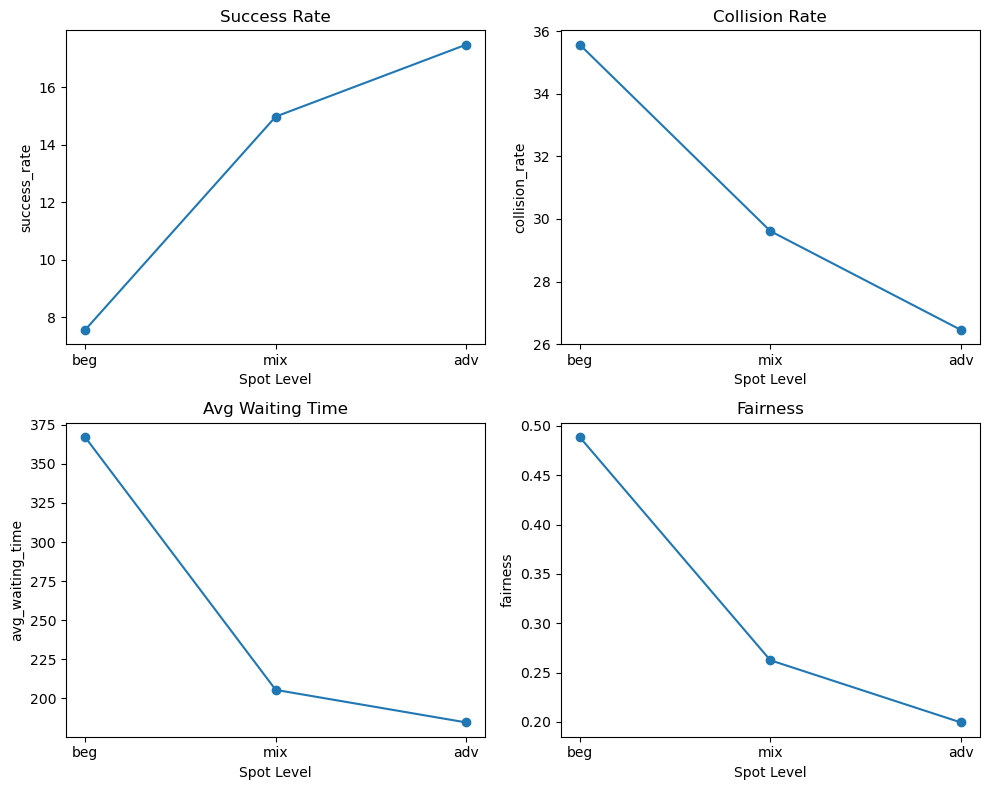

In [24]:
# AI matplotlib assistance

import matplotlib.pyplot as plt

metrics = ["success_rate", "collision_rate", "avg_waiting_time", "fairness"]
spot_levels = ["beg", "mix", "adv"]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]

    values = []
    for spot in spot_levels:
        values.append(df_level.loc[("free-for-all", spot, metric), "mean"])

    ax.plot(spot_levels, values, marker='o')
    ax.set_title(metric.replace("_", " ").title())
    ax.set_xlabel("Spot Level")
    ax.set_ylabel(metric)

plt.tight_layout()
plt.show()

#### Hypothesis 2: Under the same spot level (L), the “first-in-line” rule leads to at least 20% lower Gini and 30% fewer collisions than the “free-for-all” rule.

In [26]:
dataframes = []

for level in ["beginner", "mixed", "advanced"]:
    # run for both rule types
    mean_free, std_free = run_many(rule_type="free_for_all", num_surfer=80, spot_level=level)
    mean_first, std_first = run_many(rule_type="safe_distance", num_surfer=80, spot_level=level)
    
    mean = {
        "free_mean": mean_free,
        "safe_mean": mean_first
    }
    
    std = {
        "free_std": std_free,
        "safe_std": std_first
    }

    df = summary_table(mean, std, label_name="rule_type")
    df["spot_level"] = level
    dataframes.append(df)

In [27]:
# total summary table
h2_all_tables = pd.concat(dataframes)
h2_all_tables = h2_all_tables.set_index(["spot_level", "rule_type", "metric"])
print(h2_all_tables.round(3))

                                           mean      std
spot_level rule_type metric                             
beginner   free      n_surfers           80.000    0.000
                     wave_counts       2064.050   57.246
                     success_rate         7.092    0.505
                     collision_rate      33.704    0.946
                     avg_waiting_time   389.783   29.958
                     fairness             0.504    0.033
           safe      n_surfers           80.000    0.000
                     wave_counts       2065.100   54.977
                     success_rate         6.147    0.776
                     collision_rate      31.649    0.675
                     avg_waiting_time   460.241   60.552
                     fairness             0.559    0.048
mixed      free      n_surfers           80.000    0.000
                     wave_counts       2677.400   97.157
                     success_rate        14.708    0.723
                     collision_

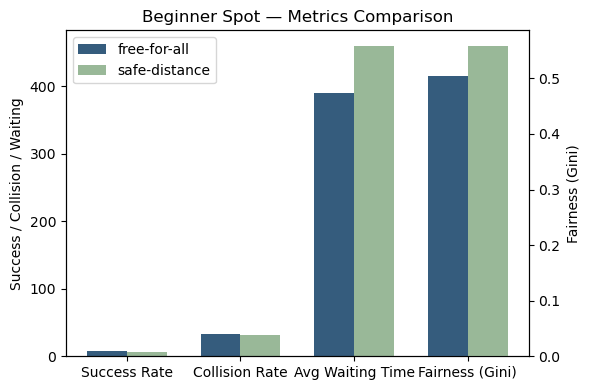

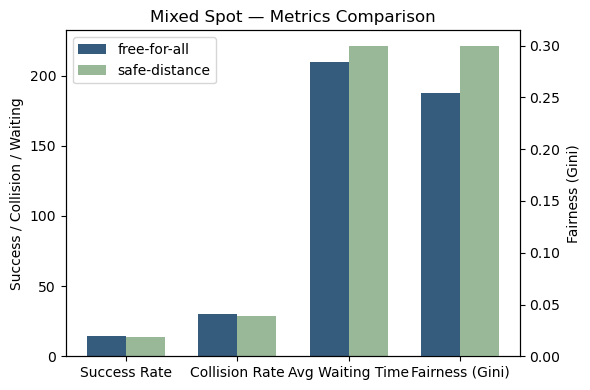

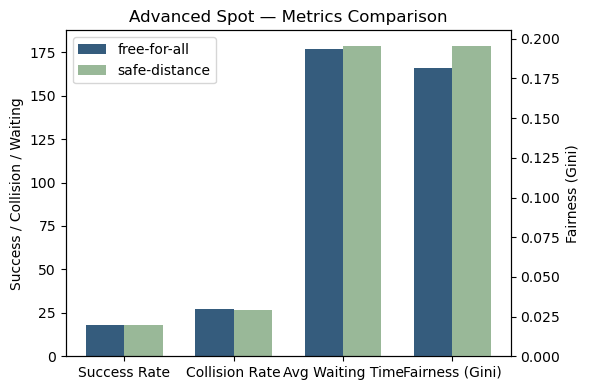

In [28]:
# AI matplotlib assistance

import matplotlib.pyplot as plt
import numpy as np

metrics = ["success_rate", "collision_rate", "avg_waiting_time", "fairness"]
metric_titles = ["Success Rate", "Collision Rate", "Avg Waiting Time", "Fairness (Gini)"]
spot_levels = ["beginner", "mixed", "advanced"]

rule_labels = {"free": "free-for-all", "safe": "safe-distance"}
colors = ["#355C7D", "#99B898"]


for level in spot_levels:
    fig, ax_left = plt.subplots(figsize=(6, 4))
    
    # secondary axis for fairness
    ax_right = ax_left.twinx()  

    x = np.arange(len(metrics))
    bar_width = 0.35

    # extract values
    free_vals = [h2_all_tables.loc[(level, "free", m), "mean"] for m in metrics]
    first_vals = [h2_all_tables.loc[(level, "safe", m), "mean"] for m in metrics]

    # split metrics: fairness goes to right axis
    fairness_idx = metrics.index("fairness")

    # left-axis metrics masks
    left_idx = [i for i in range(len(metrics)) if i != fairness_idx]

    # --- draw left-axis bars ---
    ax_left.bar(x[left_idx] - bar_width/2,
                [free_vals[i] for i in left_idx],
                bar_width, label=rule_labels["free"],
                color=colors[0])

    ax_left.bar(x[left_idx] + bar_width/2,
                [first_vals[i] for i in left_idx],
                bar_width, label=rule_labels["safe"],
                color=colors[1])

    # --- draw right-axis bars for fairness only ---
    ax_right.bar(x[fairness_idx] - bar_width/2,
                 free_vals[fairness_idx],
                 bar_width, color=colors[0])

    ax_right.bar(x[fairness_idx] + bar_width/2,
                 first_vals[fairness_idx],
                 bar_width, color=colors[1])

    # labels / formatting
    ax_left.set_xticks(x)
    ax_left.set_xticklabels(metric_titles)
    ax_left.set_title(f"{level.capitalize()} Spot — Metrics Comparison")

    ax_left.set_ylabel("Success / Collision / Waiting")
    ax_right.set_ylabel("Fairness (Gini)")

    # legend only from left axis
    ax_left.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

#### Hypothesis 3: When average wave height increases by 50%, waiting time becomes longer. Skilled surfers maintain high success rates with no major rise in collisions, but if most surfers are beginners, success drops sharply (about +30%).

In [30]:
import copy

# baseline config
base = SPOT_CONF["beginner"]

# wave-enhanced config
wave50 = copy.deepcopy(base)
wave50["wave_height"]["mu"] *= 1.5
wave50["wave_height"]["max"] += 2.0

In [31]:
dataframes_h3 = []

for ratio in [0, 0.2, 0.4, 0.6, 0.8]:
    # run for different beginner ratio
    mean_base, std_base = run_many(mode="experiment", ratio=ratio, spot_conf=base, spot_level="beginner")
    mean_wave50, std_wave50 = run_many(mode="experiment", ratio=ratio, spot_conf=wave50, spot_level="beginner")
    
    mean = {
        "base_mean": mean_base,
        "wave50_mean": mean_wave50
    }
    
    std = {
        "base_std": std_base,
        "wave50_std": std_wave50
    }

    df_h3 = summary_table(mean, std, label_name="wave_height")
    df_h3["beg_ratio"] = int(ratio * 100)
    df_h3["spot_level"] = "beginner"
    dataframes_h3.append(df_h3)

In [32]:
# total summary table
h3_all_tables = pd.concat(dataframes_h3)
h3_all_tables = h3_all_tables.set_index(["spot_level", "beg_ratio", "metric"])
print(h3_all_tables)

                                      wave_height         mean         std
spot_level beg_ratio metric                                               
beginner   0         n_surfers               base    80.000000    0.000000
                     wave_counts             base  2105.950000   60.968909
                     success_rate            base    14.321250    0.788393
                     collision_rate          base    28.760000    0.420029
                     avg_waiting_time        base   208.702006    8.785961
                     fairness                base     0.251540    0.029365
                     n_surfers             wave50    80.000000    0.000000
                     wave_counts           wave50  2073.650000   56.924026
                     success_rate          wave50    14.258125    0.627983
                     collision_rate        wave50    28.719375    0.313130
                     avg_waiting_time      wave50   206.633363    6.752959
                     fair

/var/folders/1q/8wfrycxj3mldfpmmqf_1kvbr0000gn/T/ipykernel_34550/3622840687.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_row = h3_all_tables.loc[("beginner", r, metric)]


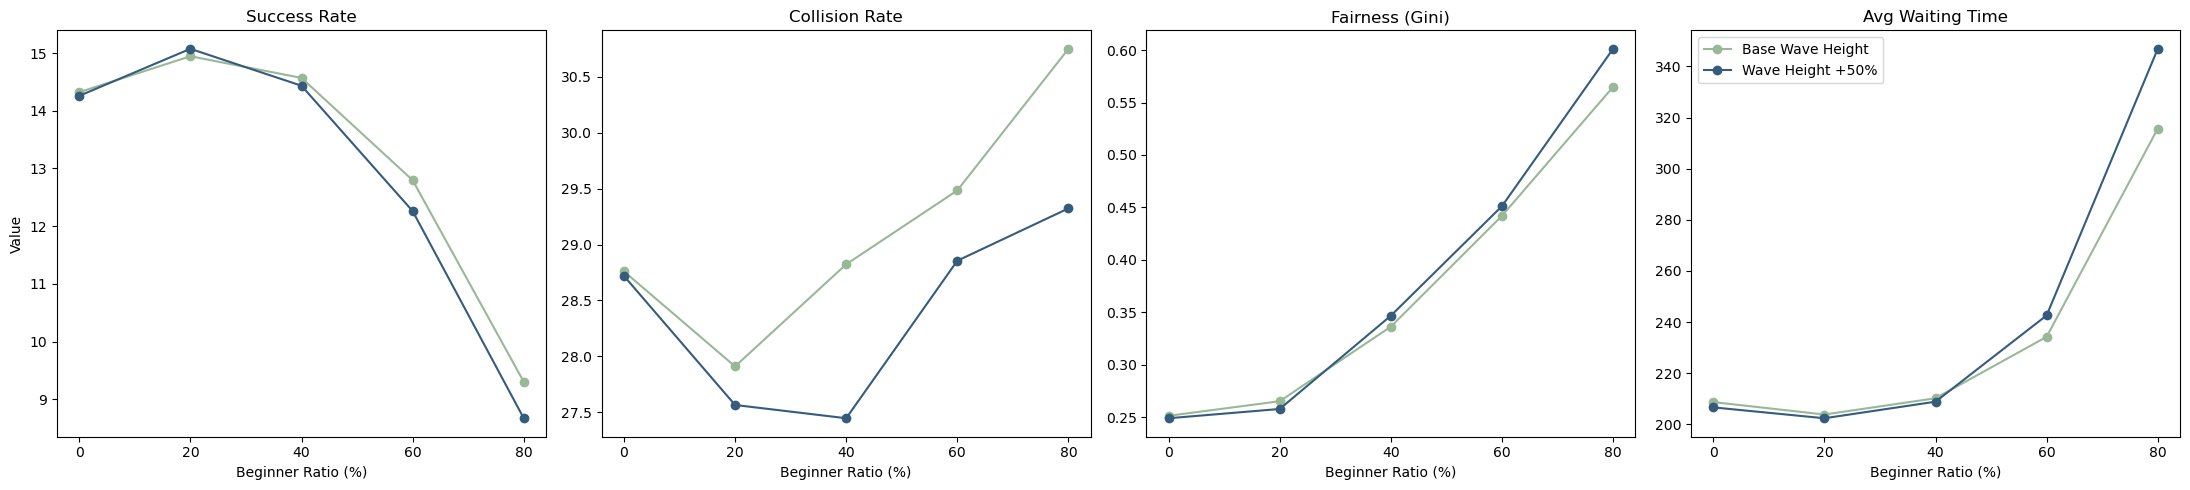

In [33]:
import matplotlib.pyplot as plt

metrics = ["success_rate", "collision_rate", "fairness", "avg_waiting_time"]
titles = ["Success Rate", "Collision Rate", "Fairness (Gini)", "Avg Waiting Time"]
ratios = [0, 20, 40, 60, 80]

fig, axes = plt.subplots(1, 4, figsize=(22, 5))

for idx, metric in enumerate(metrics):
    ax = axes[idx]

    base_vals = []
    wave50_vals = []

    for r in ratios:
        # pull out the two-row dataframe
        df_row = h3_all_tables.loc[("beginner", r, metric)]

        base_val = df_row.loc[df_row["wave_height"] == "base", "mean"].iloc[0]
        wave50_val = df_row.loc[df_row["wave_height"] == "wave50", "mean"].iloc[0]

        base_vals.append(base_val)
        wave50_vals.append(wave50_val)

    # plot lines
    ax.plot(ratios, base_vals, marker="o", color="#99B898", label="Base Wave Height")
    ax.plot(ratios, wave50_vals, marker="o", color="#355C7D", label="Wave Height +50%")

    ax.set_title(titles[idx])
    ax.set_xlabel("Beginner Ratio (%)")
    ax.set_xticks(ratios)

    if idx == 0:
        ax.set_ylabel("Value")

    if idx == 3:
        ax.legend()

plt.tight_layout()
plt.show()


Analysis: <br> From the results, we can see that the success rate drops as expected, while the collision rate decreases instead of increasing. The main reason is that collisions are counted only when surfers are riding the same wave at the same time and are close enough to each other. When there are more beginners, surfers spend less time riding waves (as reflected in the lower success rate). Consequently, the collision rate decreases as the beginner ratio increases.

# ---------------------------------------------------------------------------------

Test case

In [37]:
results = []

for ratio in [0, 0.2, 0.4, 0.6, 0.8]:
    res = run_simulation(mode="experiment", ratio=ratio, spot_conf=wave50, spot_level="mixed")
    results.append(res)
    
df = pd.DataFrame(results)
df

,spot_level,n_surfers,beginner_ratio,wave_counts,success_rate,collision_rate,avg_waiting_time,fairness
0,mixed,80,0.0,2086,12.9375,28.1875,224.409662,0.307959
1,mixed,80,0.2,2021,15.0125,27.9625,200.801832,0.247138
2,mixed,80,0.4,2111,13.9375,28.6250,218.941704,0.332029
3,mixed,80,0.6,2209,12.9125,29.9875,235.210068,0.459112
4,mixed,80,0.8,2132,8.2125,28.2000,355.108067,0.624867


In [38]:
results = []

for ratio in [0, 0.2, 0.4, 0.6, 0.8]:
    res = run_simulation(mode="experiment", ratio=ratio, spot_level="advanced")
    results.append(res)
    
df = pd.DataFrame(results)
df

,spot_level,n_surfers,beginner_ratio,wave_counts,success_rate,collision_rate,avg_waiting_time,fairness
0,advanced,80,0.0,3228,19.0250,27.6500,170.043364,0.193824
1,advanced,80,0.2,3328,17.3250,24.1375,184.629870,0.305844
2,advanced,80,0.4,3281,15.1500,20.6500,207.221122,0.396700
3,advanced,80,0.6,3240,12.9000,17.3375,237.492248,0.481638
4,advanced,80,0.8,3517,8.5875,13.3500,336.443959,0.657478


In [39]:
results = []

for type in ['free_for_all', 'first_in_line']:
    res = run_simulation(rule_type=type, num_surfer=80, spot_level="beginner")
    results.append(res)
    
df = pd.DataFrame(results)
df

,spot_level,n_surfers,beginner_ratio,wave_counts,success_rate,collision_rate,avg_waiting_time,fairness
0,beginner,80,None,2014,7.3125,33.9500,378.042735,0.499893
1,beginner,80,None,2068,6.3625,33.4125,436.941061,0.481017


In [40]:
results = []

for type in ['free_for_all', 'first_in_line']:
    res = run_simulation(rule_type=type, num_surfer=80, spot_level="mixed")
    results.append(res)
    
df = pd.DataFrame(results)
df

,spot_level,n_surfers,beginner_ratio,wave_counts,success_rate,collision_rate,avg_waiting_time,fairness
0,mixed,80,None,2845,16.2625,28.8750,186.670254,0.269591
1,mixed,80,None,2616,14.0125,30.4625,217.194469,0.250725


In [41]:
results = []

for type in ['free_for_all', 'first_in_line']:
    res = run_simulation(rule_type=type, num_surfer=80, spot_level="advanced")
    results.append(res)
    
df = pd.DataFrame(results)
df

,spot_level,n_surfers,beginner_ratio,wave_counts,success_rate,collision_rate,avg_waiting_time,fairness
0,advanced,80,None,3195,18.2875,27.1375,178.546822,0.181861
1,advanced,80,None,3391,17.8250,27.0875,182.816269,0.192146


In [42]:
results = []

for level in ["beginner", "mixed", "advanced"]:
    res = run_simulation(mode="realistic", spot_conf=SPOT_CONF[level], spot_level=level, num_surfer=80)
    results.append(res)
    
df = pd.DataFrame(results)
df

,spot_level,n_surfers,beginner_ratio,wave_counts,success_rate,collision_rate,avg_waiting_time,fairness
0,beginner,80,None,2094,6.0375,33.3375,441.217391,0.529633
1,mixed,80,None,2714,15.2375,28.8750,204.922067,0.235449
2,advanced,80,None,3378,16.6500,27.5000,187.598348,0.247222


In [43]:
# Run for both rule types
mean_free, std_free = run_many(rule_type="free_for_all", num_surfer=80, spot_level="advanced")
mean_first, std_first = run_many(rule_type="first_in_line", num_surfer=80, spot_level="advanced")

# # Compare metrics
# collision_drop = 1 - mean_first["collision_rate"] / mean_free["collision_rate"]
# gini_drop      = 1 - mean_first["fairness"] / mean_free["fairness"]

mean = {
    "free_mean": mean_free,
    "first_mean": mean_first
}

std = {
    "free_std": std_free,
    "first_std": std_first
}

df_adv = summary_table(mean, std, label_name="rule_type")
df_adv = df_adv.set_index(["rule_type", "metric"])
print(df_adv)

                                   mean         std
rule_type metric                                   
free      n_surfers           80.000000    0.000000
          wave_counts       3308.350000  117.582345
          success_rate        18.018125    0.465283
          collision_rate      27.055625    0.468331
          avg_waiting_time   179.141525    3.824738
          fairness             0.195862    0.023273
first     n_surfers           80.000000    0.000000
          wave_counts       3317.450000   97.503293
          success_rate        18.265625    0.757776
          collision_rate      27.003750    0.580198
          avg_waiting_time   176.763090    5.720743
          fairness             0.189584    0.022626
